In [1]:
import numpy as np
import pandas as pd
import time as t
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import sklearn as skl
from sklearn.model_selection import train_test_split,LeaveOneOut,KFold,cross_val_score
from sklearn.metrics import accuracy_score,r2_score,mean_squared_error,mean_absolute_error
from sklearn.linear_model import Ridge,Lasso,RidgeCV,LassoCV

In [2]:
df=pd.read_csv('insurance.csv')
test=df.copy() # making a copy of original dataset for testing purposes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<AxesSubplot:xlabel='children'>

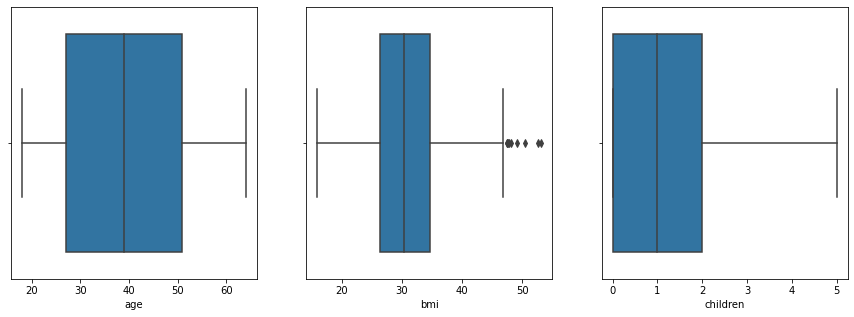

In [5]:
# checking for outliers in independent variables
import warnings
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
sns.boxplot(df.age,ax=axes[0])
sns.boxplot(df.bmi,ax=axes[1])
sns.boxplot(df.children,ax=axes[2])

In [6]:
# bmi has outliers we need to check for high leverage points
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers
outliers = find_outliers_IQR(df['bmi'])
print(outliers)

116     49.06
286     48.07
401     47.52
543     47.41
847     50.38
860     47.60
1047    52.58
1088    47.74
1317    53.13
Name: bmi, dtype: float64


In [7]:
# checking for high leverage points in bmi
fit=smf.ols('charges~bmi',df).fit()
influence=fit.get_influence()
leverage = influence.hat_matrix_diag
df['bmi'].iloc[np.argmax(leverage)]
# largest outlier is the high leverage points hence we will not drop any outliers

53.13

In [8]:
# checking for any anomalies in character variables
print(df['sex'].value_counts())
print(df['smoker'].value_counts())
print(df['region'].value_counts())

male      676
female    662
Name: sex, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


In [9]:
# scaling the continous independent variables
def scaling(df,y):
    a=df.dtypes.to_dict()
    for i in a:
        if i!=y and a[i]!='object':
            df[i]=scale(df[i],with_mean=True,with_std=True)
    return df 
df=scaling(df,'charges')

In [10]:
test=test[['age','bmi','children']]
X=add_constant(test)
vif_df=pd.DataFrame()
vif_df['Feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]
print(vif_df)
# continous independent variables are not collinear

    Feature        VIF
0     const  31.954929
1       age   1.013816
2       bmi   1.012152
3  children   1.001874


In [11]:
fit1=smf.ols('charges~age+bmi+children+smoker+sex',df).fit()
fit1.summary() #region does not have any affect on charges

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     798.0
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:41:52   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1332   BIC:                         2.715e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      8456.7832    246.768     34.270      0.000    7972.688    8940.879
smoker[T.yes]  2.382e+04    412.523     57.750      0.000     2.3e+04    2.46e+04
sex[T.male]    -128.6399    333.361     -0.386      0.700    -782.609     525.329
age            3619.8129    167.187     21.651      0.000    3291.835    3947.791
bmi            1965.1025    167.141     11.757      0.000    1637.214    2292.991
children        571.6854    166.122      3.441      0.001     245.796     897.575
==============================================================================
Omnibus:                      301.103   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              720.380
Skew:                           1.214   Prob(JB):                    3.73e-157
Kurtosis:                       5.650   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# OneHotEncoding for smoker
df=pd.get_dummies(df,columns=['smoker','sex'])

In [13]:
# splitting the dataset into training and testing
df_train,df_test = train_test_split(df,train_size=0.8,test_size=0.2, random_state=11)

<AxesSubplot:xlabel='age', ylabel='charges'>

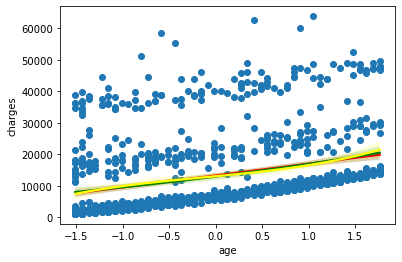

In [14]:
plt.scatter(df_train.age,df_train.charges)
sns.regplot(df_train.age,df_train.charges,order=1,scatter=False,color='red')
sns.regplot(df_train.age,df_train.charges,order=2,scatter=False,color='green')
sns.regplot(df_train.age,df_train.charges,order=3,scatter=False,color='yellow')

<AxesSubplot:xlabel='bmi', ylabel='charges'>

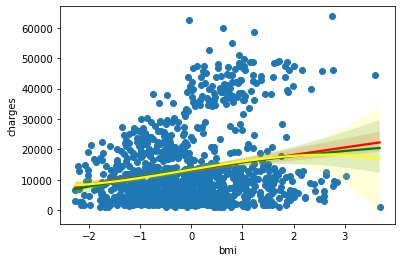

In [15]:
plt.scatter(df_train.bmi,df_train.charges)
sns.regplot(df_train.bmi,df_train.charges,order=1,scatter=False,color='red')
sns.regplot(df_train.bmi,df_train.charges,order=2,scatter=False,color='green')
sns.regplot(df_train.bmi,df_train.charges,order=3,scatter=False,color='yellow')

In [16]:
# finding best model for age
fit1=smf.ols('charges~age',df_train).fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     113.4
Date:                Fri, 07 Apr 2023   Prob (F-statistic):           3.09e-25
Time:                        18:41:54   Log-Likelihood:                -11531.
No. Observations:                1070   AIC:                         2.307e+04
Df Residuals:                    1068   BIC:                         2.308e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.33e+04    354.548     37.512      0.000    1.26e+04     1.4e+04
age         3736.1561    350.852     10.649      0.000    3047.719    4424.593
==============================================================================
Omnibus:                      331.442   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              737.250
Skew:                           1.759   Prob(JB):                    8.09e-161
Kurtosis:                       5.041   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
fit2=smf.ols('charges~I(age**2)',df_train).fit()
fit2.summary() # age is in linear relationship with charge since higher power of age are insignificant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.467
Date:                Fri, 07 Apr 2023   Prob (F-statistic):              0.117
Time:                        18:41:54   Log-Likelihood:                -11584.
No. Observations:                1070   AIC:                         2.317e+04
Df Residuals:                    1068   BIC:                         2.318e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.266e+04    572.285     22.117      0.000    1.15e+04    1.38e+04
I(age ** 2)   668.2778    425.494      1.571      0.117    -166.621    1503.177
==============================================================================
Omnibus:                      279.518   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              557.152
Skew:                           1.532   Prob(JB):                    1.04e-121
Kurtosis:                       4.763   Cond. No.                         2.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# finding best model for bmi
fit3=smf.ols('charges~bmi',df_train).fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     45.58
Date:                Fri, 07 Apr 2023   Prob (F-statistic):           2.40e-11
Time:                        18:41:54   Log-Likelihood:                -11562.
No. Observations:                1070   AIC:                         2.313e+04
Df Residuals:                    1068   BIC:                         2.314e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.333e+04    365.166     36.512      0.000    1.26e+04     1.4e+04
bmi         2439.8088    361.398      6.751      0.000    1730.677    3148.941
==============================================================================
Omnibus:                      214.598   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              358.127
Skew:                           1.305   Prob(JB):                     1.71e-78
Kurtosis:                       4.106   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# finding best model for bmi
fit4=smf.ols('charges~I(bmi**2)',df_train).fit()
fit4.summary() # bmi is in linear relationship with charge since higher power of bmi are insignificant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6787
Date:                Fri, 07 Apr 2023   Prob (F-statistic):              0.410
Time:                        18:41:54   Log-Likelihood:                -11584.
No. Observations:                1070   AIC:                         2.317e+04
Df Residuals:                    1068   BIC:                         2.318e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.312e+04    458.470     28.617      0.000    1.22e+04     1.4e+04
I(bmi ** 2)   215.3790    261.443      0.824      0.410    -297.621     728.379
==============================================================================
Omnibus:                      276.882   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              545.486
Skew:                           1.528   Prob(JB):                    3.54e-119
Kurtosis:                       4.701   Cond. No.                         2.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# finding best model for children
fit5=smf.ols('charges~children',df_train).fit()
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     7.055
Date:                Fri, 07 Apr 2023   Prob (F-statistic):            0.00802
Time:                        18:41:54   Log-Likelihood:                -11581.
No. Observations:                1070   AIC:                         2.317e+04
Df Residuals:                    1068   BIC:                         2.318e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.336e+04    371.743     35.944      0.000    1.26e+04    1.41e+04
children    1000.0417    376.497      2.656      0.008     261.284    1738.800
==============================================================================
Omnibus:                      284.313   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              571.871
Skew:                           1.554   Prob(JB):                    6.60e-125
Kurtosis:                       4.779   Cond. No.                         1.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# finding best model for children
fit6=smf.ols('charges~I(children**2)',df_train).fit()
fit6.summary() # children is in linear relationship with charge since higher power of children are insignificant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1275
Date:                Fri, 07 Apr 2023   Prob (F-statistic):              0.721
Time:                        18:41:54   Log-Likelihood:                -11585.
No. Observations:                1070   AIC:                         2.317e+04
Df Residuals:                    1068   BIC:                         2.318e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.325e+04    450.515     29.409      0.000    1.24e+04    1.41e+04
I(children ** 2)    92.6109    259.382      0.357      0.721    -416.346     601.568
==============================================================================
Omnibus:                      280.850   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              560.049
Skew:                           1.541   Prob(JB):                    2.44e-122
Kurtosis:                       4.751   Cond. No.                         2.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# best model with only continous variables
fit7=smf.ols('charges~age+bmi+children',df_train).fit()
fit7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     52.32
Date:                Fri, 07 Apr 2023   Prob (F-statistic):           1.51e-31
Time:                        18:41:54   Log-Likelihood:                -11511.
No. Observations:                1070   AIC:                         2.303e+04
Df Residuals:                    1066   BIC:                         2.305e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.332e+04    348.564     38.201      0.000    1.26e+04     1.4e+04
age         3466.6998    347.505      9.976      0.000    2784.827    4148.572
bmi         2017.5117    347.309      5.809      0.000    1336.026    2698.998
children     827.5712    353.292      2.342      0.019     134.344    1520.798
==============================================================================
Omnibus:                      268.891   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              507.127
Skew:                           1.536   Prob(JB):                    7.57e-111
Kurtosis:                       4.393   Cond. No.                         1.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
fit8=smf.ols('charges~age+bmi*children',df_train).fit()
fit8.summary() # interaction effect are insignificant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     39.30
Date:                Fri, 07 Apr 2023   Prob (F-statistic):           1.01e-30
Time:                        18:41:54   Log-Likelihood:                -11511.
No. Observations:                1070   AIC:                         2.303e+04
Df Residuals:                    1065   BIC:                         2.306e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.331e+04    348.724     38.174      0.000    1.26e+04     1.4e+04
age           3467.8670    347.621      9.976      0.000    2785.767    4149.967
bmi           2022.8558    347.543      5.820      0.000    1340.909    2704.803
children       825.9344    353.415      2.337      0.020     132.466    1519.403
bmi:children   203.4329    354.842      0.573      0.567    -492.836     899.702
==============================================================================
Omnibus:                      268.929   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              507.476
Skew:                           1.535   Prob(JB):                    6.35e-111
Kurtosis:                       4.399   Cond. No.                         1.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
fit9=smf.ols('charges~age*bmi+children',df_train).fit()
fit9.summary() # interaction effect are insignificant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     39.22
Date:                Fri, 07 Apr 2023   Prob (F-statistic):           1.16e-30
Time:                        18:41:54   Log-Likelihood:                -11511.
No. Observations:                1070   AIC:                         2.303e+04
Df Residuals:                    1065   BIC:                         2.306e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.333e+04    351.168     37.946      0.000    1.26e+04     1.4e+04
age         3469.5077    347.856      9.974      0.000    2786.947    4152.069
bmi         2014.7159    347.658      5.795      0.000    1332.544    2696.888
age:bmi      -82.7658    344.976     -0.240      0.810    -759.677     594.145
children     827.0084    353.456      2.340      0.019     133.459    1520.558
==============================================================================
Omnibus:                      268.858   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              507.048
Skew:                           1.536   Prob(JB):                    7.87e-111
Kurtosis:                       4.393   Cond. No.                         1.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
fit10=smf.ols('charges~age*bmi*children',df_train).fit()
fit10.summary() # interaction effect are insignificant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     22.60
Date:                Fri, 07 Apr 2023   Prob (F-statistic):           1.17e-28
Time:                        18:41:54   Log-Likelihood:                -11511.
No. Observations:                1070   AIC:                         2.304e+04
Df Residuals:                    1062   BIC:                         2.308e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.331e+04    352.004     37.807      0.000    1.26e+04     1.4e+04
age               3457.6093    362.669      9.534      0.000    2745.979    4169.239
bmi               2015.0254    348.184      5.787      0.000    1331.819    2698.232
age:bmi             68.3518    373.360      0.183      0.855    -664.254     800.958
children           774.6088    356.786      2.171      0.030      74.523    1474.695
age:children       -34.6785    377.583     -0.092      0.927    -775.571     706.214
bmi:children       196.0548    358.015      0.548      0.584    -506.443     898.553
age:bmi:children   448.5776    408.716      1.098      0.273    -353.405    1250.561
==============================================================================
Omnibus:                      269.070   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              508.310
Skew:                           1.534   Prob(JB):                    4.19e-111
Kurtosis:                       4.411   Cond. No.                         1.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# adding categorical values 
fit11=smf.ols('charges~age+bmi+children+smoker_yes+sex_male',df_train).fit()
fit11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     598.6
Date:                Fri, 07 Apr 2023   Prob (F-statistic):          3.40e-306
Time:                        18:41:54   Log-Likelihood:                -10869.
No. Observations:                1070   AIC:                         2.175e+04
Df Residuals:                    1064   BIC:                         2.178e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8650.9803    285.607     30.290      0.000    8090.564    9211.397
age         3715.2833    190.866     19.465      0.000    3340.767    4089.800
bmi         1999.1601    190.935     10.470      0.000    1624.509    2373.811
children     651.1787    194.001      3.357      0.001     270.511    1031.847
smoker_yes  2.353e+04    473.698     49.684      0.000    2.26e+04    2.45e+04
sex_male    -401.4244    383.872     -1.046      0.296   -1154.657     351.808
==============================================================================
Omnibus:                      255.904   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              602.840
Skew:                           1.286   Prob(JB):                    1.24e-131
Kurtosis:                       5.629   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# best model on testing data
x=pd.DataFrame(df_test[['age','bmi','children','smoker_yes','sex_male']])
y=df_test.charges
model=lm.LinearRegression()
model.fit(x,y)
kfold5=KFold(n_splits=10,random_state=1,shuffle=True)
test5=cross_val_score(model,x,y,cv=kfold5,scoring='neg_mean_squared_error',n_jobs=-1)
print(np.mean(-test5))

28004965.762863655


In [28]:
# best model on testing data
x=pd.DataFrame(df_test[['age','bmi','children']])
y=df_test.charges
model=lm.LinearRegression()
model.fit(x,y)
kfold5=KFold(n_splits=10,random_state=1,shuffle=True)
test5=cross_val_score(model,x,y,cv=kfold5,scoring='neg_mean_squared_error',n_jobs=-1)
print(np.mean(-test5))

130189121.74744451


In [29]:
# best model on testing data
x=pd.DataFrame(df_test[['age','bmi','children','smoker_yes','sex_male','sex_female']])
y=df_test.charges
model=lm.LinearRegression()
model.fit(x,y)
kfold5=KFold(n_splits=10,random_state=1,shuffle=True)
test5=cross_val_score(model,x,y,cv=kfold5,scoring='neg_mean_squared_error',n_jobs=-1)
print(np.mean(-test5))

28004965.762863666


In [30]:
# best model with categorical values 
fit11=smf.ols('charges~age+bmi+children+smoker_yes+sex_male+sex_female',df_train).fit()
fit11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     598.6
Date:                Fri, 07 Apr 2023   Prob (F-statistic):          3.40e-306
Time:                        18:41:58   Log-Likelihood:                -10869.
No. Observations:                1070   AIC:                         2.175e+04
Df Residuals:                    1064   BIC:                         2.178e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5633.5120    143.295     39.314      0.000    5352.339    5914.685
age         3715.2833    190.866     19.465      0.000    3340.767    4089.800
bmi         1999.1601    190.935     10.470      0.000    1624.509    2373.811
children     651.1787    194.001      3.357      0.001     270.511    1031.847
smoker_yes  2.353e+04    473.698     49.684      0.000    2.26e+04    2.45e+04
sex_male    2616.0438    206.064     12.695      0.000    2211.706    3020.382
sex_female  3017.4682    203.674     14.815      0.000    2617.819    3417.117
==============================================================================
Omnibus:                      255.904   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              602.840
Skew:                           1.286   Prob(JB):                    1.24e-131
Kurtosis:                       5.629   Cond. No.                     1.26e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.05e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""